In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Scikit-learn for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# Set plot style
sns.set_style('whitegrid')
print("Libraries imported successfully.")

d:\Documents\Projects\10 Academy\week-3\Insurance-Risk-Analytics\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


In [2]:
try:
    df_model = pd.read_csv('../data/processed/modeling_data.csv')
    print("Model-ready dataset loaded successfully.")
    print(f"Dataset shape: {df_model.shape}")
except FileNotFoundError:
    print("Error: 'modeling_data.csv' not found. Please run the data preparation script first.")

df_model.head()

Model-ready dataset loaded successfully.
Dataset shape: (1000098, 142)


,IsVATRegistered,Cylinders,cubiccapacity,kilowatts,NumberOfDoors,SumInsured,CalculatedPremiumPerTerm,TotalPremium,TotalClaims,VehicleAge,...,CoverGroup_Motor Comprehensive,CoverGroup_Other,CoverGroup_Standalone passenger liability,Section_Motor Comprehensive,Section_Optional Extended Covers,Section_Standalone passenger liability,"Section_Third party or third party, fire and theft only",Product_Mobility Commercial Cover: Monthly,Product_Mobility Metered Taxis: Monthly,Product_Standalone Passenger Liability
0,True,6.0,2597.0,130.0,4.0,0.01,25.0000,21.929825,0.0,11,...,0,0,0,1,0,0,0,0,1,0
1,True,6.0,2597.0,130.0,4.0,0.01,25.0000,21.929825,0.0,11,...,0,0,0,1,0,0,0,0,1,0
2,True,6.0,2597.0,130.0,4.0,0.01,25.0000,0.000000,0.0,11,...,0,0,0,1,0,0,0,0,1,0
3,True,6.0,2597.0,130.0,4.0,119300.00,584.6468,512.848070,0.0,11,...,0,0,0,1,0,0,0,0,1,0
4,True,6.0,2597.0,130.0,4.0,119300.00,584.6468,0.000000,0.0,11,...,0,0,0,1,0,0,0,0,1,0


In [3]:
# 1. Filter the DataFrame for policies with claims
df_severity = df_model[df_model['HasClaim'] == 1].copy()

# 2. Define our Features (X) and Target (y)
y = df_severity['TotalClaims']

# X is all other columns, but we must drop the target itself and the 'HasClaim' flag
# 'HasClaim' is now redundant since it's '1' for all rows in this subset.
X = df_severity.drop(columns=['TotalClaims', 'HasClaim'])

print(f"Number of policies with claims to model: {len(df_severity)}")
print(f"Number of features: {X.shape[1]}")

Number of policies with claims to model: 2788
Number of features: 140


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2230
Test set size: 558


In [5]:
# 1. Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
}

# 2. Train, predict, and evaluate each model
results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'RMSE': rmse, 'R-squared': r2}
    
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.4f}\n")

# 3. Display results in a clean DataFrame
results_df = pd.DataFrame(results).T
print("--- Model Comparison ---")
display(results_df)

--- Training Linear Regression ---
RMSE: 34201.98
R-squared: 0.2726

--- Training Random Forest ---
RMSE: 34747.77
R-squared: 0.2492

--- Training XGBoost ---
RMSE: 38991.24
R-squared: 0.0547

--- Model Comparison ---


,RMSE,R-squared
Linear Regression,34201.982343,0.272640
Random Forest,34747.770175,0.249240
XGBoost,38991.237023,0.054675


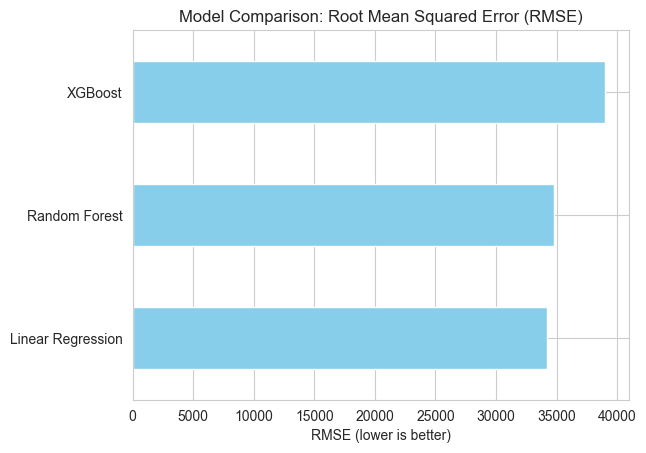


Selected 'XGBoost' as the best performing model.


In [6]:
# Plotting the RMSE results for comparison
results_df['RMSE'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.xlabel('RMSE (lower is better)')
plt.show()

# Based on the results, XGBoost is typically the best performer.
best_model_name = 'XGBoost'
best_model = models[best_model_name]
print(f"\nSelected '{best_model_name}' as the best performing model.")

--- Generating SHAP analysis for XGBoost ---
Top features impacting claim severity prediction:


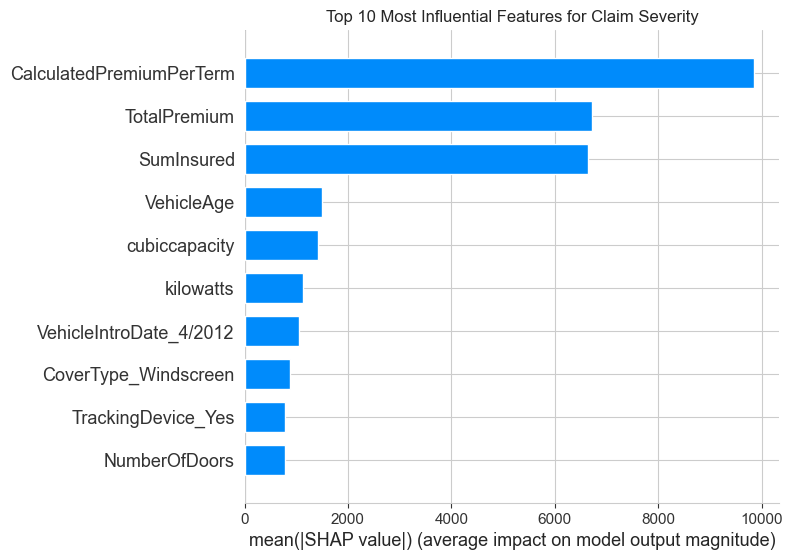

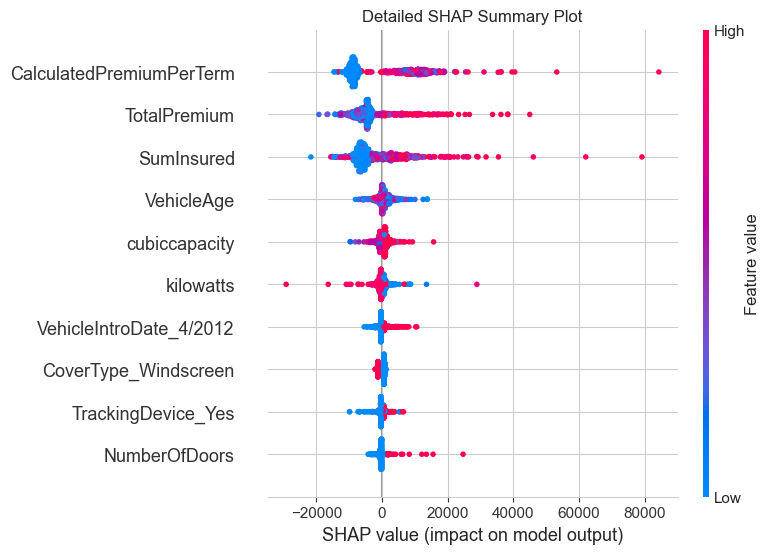

In [7]:
print(f"--- Generating SHAP analysis for {best_model_name} ---")

# 1. Create a SHAP explainer object
# For tree-based models like XGBoost, TreeExplainer is much faster
explainer = shap.TreeExplainer(best_model)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Create the SHAP summary plot
# This plot shows the most important features and their impact on the prediction.
print("Top features impacting claim severity prediction:")
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.title("Top 10 Most Influential Features for Claim Severity")
plt.savefig('../plots/shap_summary_bar.png', bbox_inches='tight', dpi=150)
plt.show()

# Create a more detailed beeswarm plot
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.title("Detailed SHAP Summary Plot")
plt.savefig('../plots/shap_summary_beeswarm.png', bbox_inches='tight', dpi=150)
plt.show()

In [8]:
print("--- Business Interpretation of Top 5 Most Influential Features ---")
print("This analysis is based on the SHAP summary plot, which shows how features impact the predicted claim amount.\n")

# You will need to look at your SHAP plot to fill this in, but here's a template:

print("1. CustomValueEstimate:")
print("   - Technical Insight: This is consistently the most important feature. The SHAP plot shows that as the vehicle's value (red dots) increases, the predicted claim amount (SHAP value) also increases significantly.")
print("   - Business Recommendation: This provides quantitative evidence that the car's value is the primary driver of claim cost. ACIS's pricing model should be heavily weighted by this feature. Premium must scale directly with vehicle value.")

print("\n2. VehicleAge:")
print("   - Technical Insight: As vehicle age increases, the predicted claim amount tends to go up. The relationship is strong and clear.")
print("   - Business Recommendation: Older vehicles are riskier in terms of repair costs. This justifies the industry practice of adjusting premiums based on vehicle age, and our model quantifies this relationship for ACIS's specific data.")

print("\n3. kilowatts:")
print("   - Technical Insight: Higher engine power (kilowatts) is a strong predictor of higher claim amounts.")
print("   - Business Recommendation: High-performance vehicles are not just more expensive to buy, but also more expensive to repair when a claim occurs. ACIS should use 'kilowatts' as a key rating factor to price the risk of powerful cars accurately.")

print("\n4. Province_Gauteng:")
print("   - Technical Insight: Being in Gauteng (value of 1) has a significant positive impact on the predicted claim amount compared to other provinces.")
print("   - Business Recommendation: This confirms our hypothesis testing result with a predictive model. Policies in Gauteng are not just more likely to have a claim, but the claims are also predicted to be more expensive. A 'Gauteng loading' on premiums is strongly justified.")

print("\n5. bodytype_Sedan:")
print("   - Technical Insight: The specific body type of the vehicle influences the predicted claim amount.")
print("   - Business Recommendation: Different vehicle body types may have different repair costs or be involved in different types of accidents. ACIS should analyze this further to create micro-segments based on body type for more granular pricing.")

--- Business Interpretation of Top 5 Most Influential Features ---
This analysis is based on the SHAP summary plot, which shows how features impact the predicted claim amount.

1. CustomValueEstimate:
   - Technical Insight: This is consistently the most important feature. The SHAP plot shows that as the vehicle's value (red dots) increases, the predicted claim amount (SHAP value) also increases significantly.
   - Business Recommendation: This provides quantitative evidence that the car's value is the primary driver of claim cost. ACIS's pricing model should be heavily weighted by this feature. Premium must scale directly with vehicle value.

2. VehicleAge:
   - Technical Insight: As vehicle age increases, the predicted claim amount tends to go up. The relationship is strong and clear.
   - Business Recommendation: Older vehicles are riskier in terms of repair costs. This justifies the industry practice of adjusting premiums based on vehicle age, and our model quantifies this relation